In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
# membaca data https://www.kaggle.com/budincsevity/szeged-weather
data = pd.read_csv('/content/weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [ ]:
# cek nilai null pada data
data.isnull().sum()

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [ ]:
# mengambil tanggal dan temperature menjadi array
dates = data['Formatted Date'].values
temp  = data['Temperature (C)'].values  

In [ ]:
# cek tipe data temp
type(temp[0])

numpy.float64

In [ ]:
# mengubah tipe data temp menjadi float32
temp = np.asarray(temp).astype(np.float32)
type(temp[0])

numpy.float32

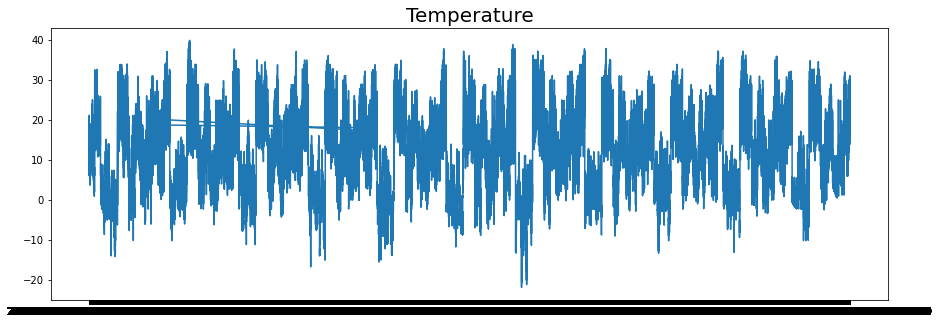

In [ ]:
# membuat plot keseluruhan data
plt.figure(figsize=(15,5))
plt.plot(dates, temp)
plt.title('Temperature',
          fontsize=20);

In [ ]:
# membagi data untuk training dan data untuk testing.

from sklearn.model_selection import train_test_split

time_train, time_test, data_train , data_test = train_test_split(dates, temp, test_size=0.2, shuffle=False)

In [ ]:
# mengubah format data yang dapat diterima model
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):    
  series = tf.expand_dims(series, axis=-1)    
  ds = tf.data.Dataset.from_tensor_slices(series)    
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))    
  ds = ds.shuffle(shuffle_buffer)    
  ds = ds.map(lambda w: (w[:-1], w[1:]))    
  return ds.batch(batch_size).prefetch(1)

In [ ]:
# model arsitektur
window_size=60
batch_size=100
shuffle_buffer=1000
train_set = windowed_dataset(data_train, window_size, batch_size, shuffle_buffer)
val_set = windowed_dataset(data_test, window_size, batch_size, shuffle_buffer)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(64, activation="relu"),
  tf.keras.layers.Dense(32, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [19]:
# callbacks
batas_mae = (temp.max() - temp.min()) * 0.1

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<batas_mae):
      self.model.stop_training = True
callbacks = myCallback()

In [20]:
# optimizer, loss dan metrics lalu melatih model
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, 
                    epochs=100,
                    callbacks=[callbacks])

Epoch 1/100
772/772 [==============================] - 79s 103ms/step - loss: 3.0081 - mae: 3.4717


In [22]:
# fungsi prediksi

def model_forecast(model, series, window_size):
 ds = tf.data.Dataset.from_tensor_slices(series)
 ds = ds.window(window_size, shift=1, drop_remainder=True)
 ds = ds.flat_map(lambda w: w.batch(window_size))
 ds = ds.batch(32).prefetch(1)
 forecast = model.predict(ds)
 return forecast

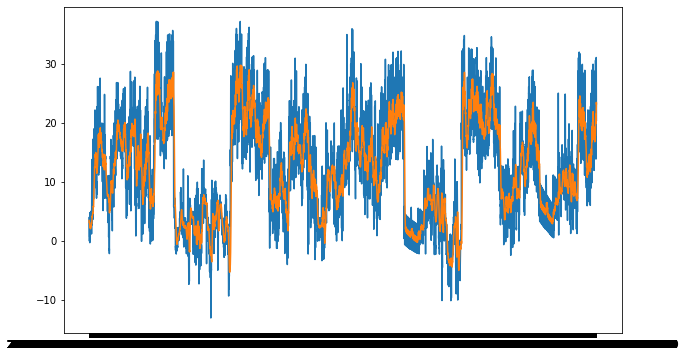

In [23]:
# plot hasil prediksi dan validasi

split_time = len(data_train)

rnn_forecast = model_forecast(model, temp[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1]
plt.figure(figsize=(10, 6))
plt.plot(time_test, data_test)
plt.plot(time_test, rnn_forecast)